In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import os
from numpy import *

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [3]:
from sklearn.svm import SVC
from sklearn import datasets

filename = '/Users/roberto/data/RO-logging/datasets/ro-dataset-v1/maxEVecs-ro-dataset.csv';
print('Reading from: ' + filename)
df_maxEVecs = pd.read_csv(filename, names=range(2400))

[m,n] = shape(df_maxEVecs)

filename = '/Users/roberto/data/RO-logging/datasets/ro-dataset-v1/labels-ro-dataset.csv';
print('Reading from: ' + filename)
df_labels = pd.read_csv(filename, names=range(m))
labels = np.copy(df_labels.values)
labels = labels.T
print("Shape of max eigenvecs is:\n",shape(df_maxEVecs))
print("Shape of labels is:\n",shape(df_labels))

Reading from: /Users/roberto/data/RO-logging/datasets/ro-dataset-v1/maxEVecs-ro-dataset.csv
Reading from: /Users/roberto/data/RO-logging/datasets/ro-dataset-v1/labels-ro-dataset.csv
Shape of max eigenvecs is:
 (2023, 2400)
Shape of labels is:
 (1, 2023)


In [4]:
where_are_NaNs = isnan(df_maxEVecs)
df_maxEVecs[where_are_NaNs] = 0
df_maxEVecs.head()

,0,1,2,3,4,5,6,7,8,9,...,2390,2391,2392,2393,2394,2395,2396,2397,2398,2399
0,0.055188,0.055134,0.054691,0.054660,0.054297,0.054235,0.054081,0.053936,0.053916,0.053564,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.048261,0.048193,0.047930,0.047750,0.047725,0.047575,0.047533,0.046977,0.046955,0.046932,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.046782,0.046761,0.046703,0.046670,0.046650,0.046623,0.046605,0.046600,0.046530,0.046512,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.048621,0.048156,0.047899,0.047863,0.047810,0.047751,0.047556,0.047522,0.047419,0.047178,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.046599,0.046410,0.046399,0.046352,0.046250,0.046162,0.046136,0.045981,0.045935,0.045744,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Handcrafted features for all data (train and test data)
eigenvectors = np.copy(df_maxEVecs.values)
max_vals = []
max_vals = eigenvectors[:,0]
num_landmarks = count_nonzero(eigenvectors,axis=1)
q1_vals = []
q3_vals = []
iqr_vals = []
area_under_curve = []

for i in range(m):
    q1_index = int(round(num_landmarks[i]/4))
    q1_vals.append(eigenvectors[i,q1_index])
    q3_index = int(round(num_landmarks[i]*3/4))
    q3_vals.append(eigenvectors[i,q3_index])
    iqr_vals.append(q1_vals[-1]-q3_vals[-1])
    
    temp_sum = 0;
    for j in range(n):
        temp_sum += eigenvectors[i,j]
    area_under_curve.append(temp_sum)
    
previous_max_vals = [max_vals[0]]
previous_max_vals = np.append(previous_max_vals,max_vals[0:m-1])
previous_num_landmarks = [num_landmarks[0]]
previous_num_landmarks = np.append(previous_num_landmarks,num_landmarks[0:m-1])
previous_q1_vals = [q1_vals[0]]
previous_q1_vals = np.append(previous_q1_vals,q1_vals[0:m-1])
previous_q3_vals = [q3_vals[0]]
previous_q3_vals = np.append(previous_q3_vals,q3_vals[0:m-1])
previous_iqr_vals = [iqr_vals[0]]
previous_iqr_vals = np.append(previous_iqr_vals,iqr_vals[0:m-1])
previous_area_under_curve = [area_under_curve[0]]
previous_area_under_curve = np.append(previous_area_under_curve,area_under_curve[0:m-1])

In [6]:
# temp_dict = {'max_vals':max_vals,'num_landmarks':num_landmarks,
#              'q1_vals':q1_vals,'q3_vals':q3_vals,'iqr_vals':iqr_vals,
#             'area_under_curve':area_under_curve,
#             'previous_max_vals':previous_max_vals,
#             'previous_num_landmarks':previous_num_landmarks,
#             'previous_q1_vals':previous_q1_vals,
#             'previous_q3_vals':previous_q3_vals,
#             'previous_iqr_vals':previous_iqr_vals,
#             'previous_area_under_curve':previous_area_under_curve}

temp_dict = {'max_vals':max_vals,'num_landmarks':num_landmarks,
            'area_under_curve':area_under_curve,
            'previous_max_vals':previous_max_vals,
            'previous_num_landmarks':previous_num_landmarks,
            'previous_area_under_curve':previous_area_under_curve}

df_features = pd.DataFrame(data = temp_dict)
df_features.head()

,max_vals,num_landmarks,area_under_curve,previous_max_vals,previous_num_landmarks,previous_area_under_curve
0,0.055188,663,24.278510,0.055188,663,24.278510
1,0.048261,706,24.570881,0.055188,663,24.278510
2,0.046782,706,25.191307,0.048261,706,24.570881
3,0.048621,696,25.408512,0.046782,706,25.191307
4,0.046599,650,24.898711,0.048621,696,25.408512


In [7]:
print(num_landmarks[0])
print(np.count_nonzero(eigenvectors[0,0:1800],axis=0))

663
663


In [28]:
from sklearn.model_selection import StratifiedShuffleSplit

print('Good RO: ',np.count_nonzero(labels==0))
print('Bad RO:',np.count_nonzero(labels==1),'\n')

X_total = np.copy(df_features.values)
y_total = np.copy(ravel(labels))

sss = StratifiedShuffleSplit(n_splits=1, test_size = 0.95, random_state=0)

for train_index, test_index in sss.split(X_total, y_total):
    X_train, X_test = X_total[train_index], X_total[test_index]
    y_train, y_test = y_total[train_index], y_total[test_index]
    eig_train, eig_test = df_maxEVecs.values[train_index], df_maxEVecs.values[test_index]

print('Good vs Bad RO in training: ',np.count_nonzero(y_train==0),'good,',np.count_nonzero(y_train==1),'bad')
print('Good vs Bad RO in testing:',np.count_nonzero(y_test==0),'good,',np.count_nonzero(y_test==1),'bad \n')

print('Good/Bad ratio in training: ',np.count_nonzero(y_train==0)/np.count_nonzero(y_train==1))
print('Good/Bad ratio in testing:',np.count_nonzero(y_test==0)/np.count_nonzero(y_test==1),'\n')

# print('Bad RO % in training: ',np.count_nonzero(y_train==1)/np.count_nonzero(labels==1))
# print('Bad RO % in testing:',np.count_nonzero(y_test==1)/np.count_nonzero(labels==1),'\n')

print('Bad RO % in training: ',np.count_nonzero(y_train==1)/len(y_train))
print('Bad RO % in testing:',np.count_nonzero(y_test==1)/len(y_test),'\n')

[m_train,n_train] = shape(X_train)
[m_test,n_test] = shape(X_test)
print("Size of training data is: \n",shape(X_train))
print("Size of test data is: \n",shape(X_test))

Good RO:  1567
Bad RO: 456 

Good vs Bad RO in training:  78 good, 23 bad
Good vs Bad RO in testing: 1489 good, 433 bad 

Good/Bad ratio in training:  3.391304347826087
Good/Bad ratio in testing: 3.438799076212471 

Bad RO % in training:  0.22772277227722773
Bad RO % in testing: 0.22528616024973985 

Size of training data is: 
 (101, 6)
Size of test data is: 
 (1922, 6)


In [29]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
# scaler = preprocessing.MaxAbsScaler().fit(X_train)
X_scaled = preprocessing.scale(X_train)
print("Mean: ",X_scaled.mean(axis=0))
print("Variance: ",X_scaled.std(axis=0))

Mean:  [ 1.59938069e-15 -1.53892300e-16 -2.73708449e-15 -1.22674148e-15
 -1.59388454e-16 -3.91326135e-16]
Variance:  [1. 1. 1. 1. 1. 1.]


In [30]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

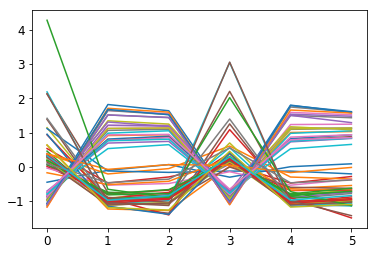

In [31]:
plt.plot(X_train[0:60,:].T,'-');

In [32]:
label_colours = []   
test_colours = []
for i in range(m_train):
    if(y_train[i] == 1):
        label_colours.append('red')
    else:
        label_colours.append('blue')
for i in range(m_test):
    if(y_test[i] == 1):
        test_colours.append('red')
    else:
        test_colours.append('blue')

# plt.figure(figsize=(15,5))

# for i in range(m_train):
#     plt.subplot(121)
#     plt.plot(eig_train[i,:].T, color=label_colours[i]);
#     plt.title("Training data", fontsize=16)

# for i in range(m_test):
#     plt.subplot(122)
#     plt.plot(eig_test[i,:].T, color=test_colours[i]);
#     plt.title("Test data", fontsize=16)

In [33]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# SVM Classifier model
# svm_clf = SVC(kernel="rbf",class_weight='balanced', C=float(100000))
clf = SVC(kernel="rbf",class_weight='balanced', C=float(1000),random_state=0)
print(clf.fit(X_train, y_train))
clf.score(X_test,y_test)

# Random Forest
# clf = RandomForestClassifier(n_estimators=10)
# clf = clf.fit(X_train,y_train)

SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)


0.840270551508845

In [34]:
print('Testing on X data with shape: ',shape(X_test))
predictions = clf.predict(X_test)
successes = 0
for i in range(len(predictions)):
    if predictions[i] == y_test[i]:
        successes+=1   
print('Successes: ',successes,' out of ',len(y_test))
print('Classification accuracy = ',successes/len(y_test))

Testing on X data with shape:  (1922, 6)
Successes:  1615  out of  1922
Classification accuracy =  0.840270551508845


In [35]:
# predict_colours = []
# correct_colours = []
# for i in range(m_test):
#     if(predictions[i] == 1):
#         predict_colours.append('red')
#     else:
#         predict_colours.append('blue')
# for i in range(m_test):
#     if(y_test[i] == 1):
#         correct_colours.append('red')
#     else:
#         correct_colours.append('blue')

# plt.figure(figsize=(15,5))
# for i in range(m_test):
# #     if(i%20 ==0):
#         plt.subplot(121)
#         plt.plot(eig_test[i,:].T, color=predict_colours[i]);
#         plt.title("Predictions", fontsize=16)

#         plt.subplot(122)
#         plt.plot(eig_test[i,:].T, color=correct_colours[i]);
#         plt.title("Ground truth", fontsize=16)

In [36]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.metrics.scorer import make_scorer

scoring = ['precision_macro', 'recall_macro']

scores = cross_validate(clf,X_train,y_train, scoring=scoring,cv=5,return_train_score=True)
scores

{'fit_time': array([0.00181699, 0.00145102, 0.00137305, 0.00143194, 0.00143003]),
 'score_time': array([0.00108385, 0.00099611, 0.00116491, 0.00172615, 0.00145507]),
 'test_precision_macro': array([0.58333333, 0.7375    , 0.66176471, 0.94117647, 0.62857143]),
 'train_precision_macro': array([0.90909091, 0.91666667, 0.89628733, 0.92037471, 0.93149541]),
 'test_recall_macro': array([0.6125, 0.7375, 0.6375, 0.75  , 0.65  ]),
 'train_recall_macro': array([0.96774194, 0.94802867, 0.93996416, 0.94987469, 0.93149541])}

In [37]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(clf,X_train, y_train, cv=5)
# y_train_pred

In [38]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train,y_train_pred)

array([[65, 13],
       [11, 12]])

In [39]:
from sklearn.metrics import precision_score, recall_score
print('Precision (% when positive prediction is correct):\n',precision_score(y_train,y_train_pred),'\n')
print('Recall (% of bad RO instances detected):\n',recall_score(y_train, y_train_pred),'\n')

from sklearn.metrics import f1_score
print('F1 score: \n',f1_score(y_train,y_train_pred))

Precision (% when positive prediction is correct):
 0.48 

Recall (% of bad RO instances detected):
 0.5217391304347826 

F1 score: 
 0.4999999999999999


In [40]:
from sklearn.model_selection import cross_val_score
y_scores = cross_val_predict(clf, X_train, y_train, cv=5,
                                 method="decision_function")
# y_scores = cross_val_predict(clf, X_train, y_train, cv=3)

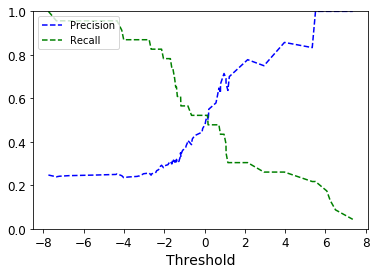

In [41]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

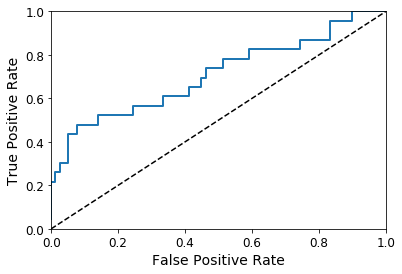

Area under ROC curve 0.7079152731326643


In [42]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()

print('Area under ROC curve',roc_auc_score(y_train, y_scores))

In [44]:
y_train_pred_thresholding = (y_scores > -0.5)
print(y_train.shape)
print(y_train)

print('Precision (% when positive prediction is correct):\n',precision_score(y_train,y_train_pred_thresholding),'\n')
print('Recall (% of bad RO instances detected):\n',recall_score(y_train, y_train_pred_thresholding),'\n')

(101,)
[0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0]
Precision (% when positive prediction is correct):
 0.42857142857142855 

Recall (% of bad RO instances detected):
 0.5217391304347826 

